# Machine Learning Assignment
Ayano Yamamoto

# Table of Contents
* [Introduction](#intro)
* [Data Import and Exploration](#p1)
* [Hold-Out Testing](#p2)
* [K-fold Cross Validation](#p3)
* [Smaller Subset Sizes](#p4)
* [Conclusion](#conclusion)
* [References](#ref)

# Introduction<a name="intro"></a>

* In this assignment we aim to demonstrate that K-fold cross validation	is a better	data splitting approach than hold-out testing when there is fewer data available. This is because there are possibilities of "lucky" splits where the difficult instances end up in the training set while the easy ones are in the test set, making the model appear more accurate than it will be when it is deployed (Kelleher, Mac Namee, & D'arcy, 2020)[<sup>1</sup>](#1).<br><br>

* The dataset used is `wine.data` from UC Irvine Machine Learning Repository[<sup>2</sup>](#2) which has 178 instances. We will first create 200 different splits for hold-out testing, train three models (GaussianNB, KNeighborsClassifier, and DecisionTreeClassifier), and plot the F1 scores in histograms. This will demonstrate the range of F1 scores between "lucky" and "unlucky" splits.<br><br>

* We will then perform 10-fold cross validations on the same models. The F1 scores from cross validations should be at a balanced point between the "lucky" and "unlucky" splits from the 200 hold-out tests, showing that it provides a more stable, and better estimate of performance on small amounts of data.<br><br>

* We will also sample subsets of increasing sizes from the dataset and perform hold-out and cross validations to see how they perform with even less data available.

# Data Import and Exploration<a name="p1"></a>

Import the libraries that are required to run the project.

In [2]:
# For data manipulation
import pandas as pd
import numpy as np

# For visualisation
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

# For preprocessing data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Three models we will use
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# For evaluation
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold

Import `wine.csv` with specified column names. This notebook expects to find the dataset at `../input/wine.csv` (i.e. the input directory is located in the directory above the notebook).

In [3]:
# Create a list of column names
column_names = ['cultivar', 'alcohol', 'malic_acid', 'ash' , 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'OD280_OD315', 'proline']

# Import `wine.data` as df
df = pd.read_csv('../input/wine.csv', names = column_names)

# Check the first few rows of df
df.head()

,cultivar,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280_OD315,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Inspect `df` for shape, variable formats, missing values, duplicates, and the basic statistics.

In [4]:
# Check the shape of the dataset
df.shape

(178, 14)

In [5]:
# Check variable formats and number of missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cultivar              178 non-null    int64  
 1   alcohol               178 non-null    float64
 2   malic_acid            178 non-null    float64
 3   ash                   178 non-null    float64
 4   alcalinity_of_ash     178 non-null    float64
 5   magnesium             178 non-null    int64  
 6   total_phenols         178 non-null    float64
 7   flavanoids            178 non-null    float64
 8   nonflavanoid_phenols  178 non-null    float64
 9   proanthocyanins       178 non-null    float64
 10  color_intensity       178 non-null    float64
 11  hue                   178 non-null    float64
 12  OD280_OD315           178 non-null    float64
 13  proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [6]:
# Check for duplicates
df.duplicated().sum()

0

In [7]:
# Check the basic statistics
df.describe()

,cultivar,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280_OD315,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Check the count of target classes.

In [8]:
# Check the count of target instaces
df['cultivar'].value_counts()

2    71
1    59
3    48
Name: cultivar, dtype: int64

Visualise the variables.

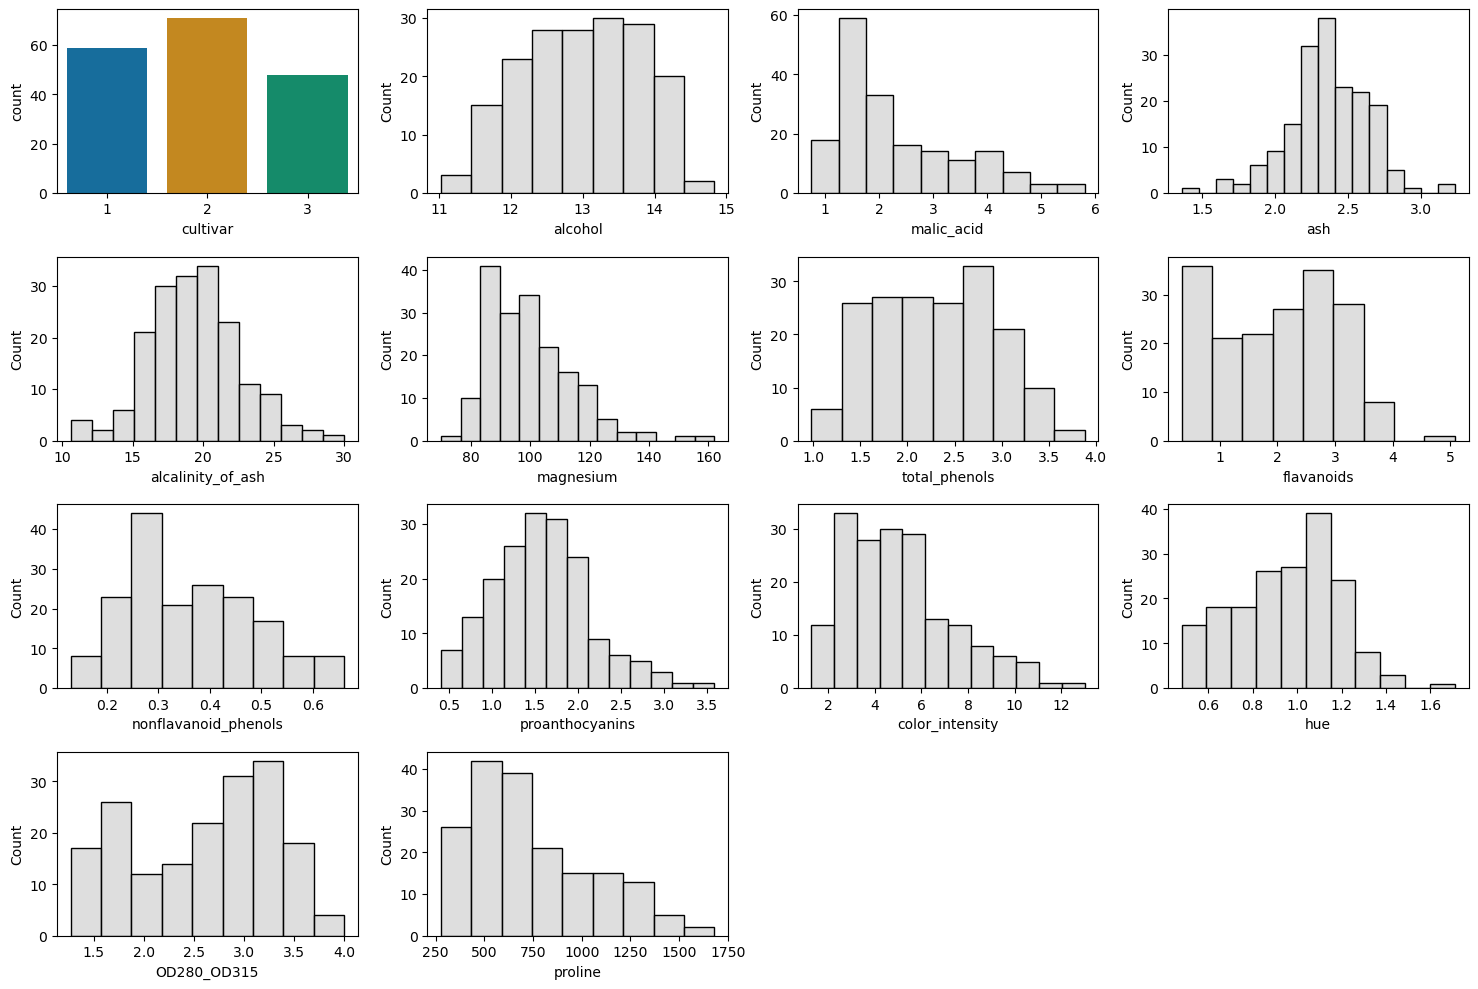

In [9]:
# Create the figure and axes with 4 row and 4 columns
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (15,10))

# Create the plots, informing the coordinate
sns.countplot(x = 'cultivar', data = df, palette = "colorblind", ax = axes[0, 0])
sns.histplot(x = 'alcohol', data = df, color = '#D3D3D3', ax = axes[0, 1])
sns.histplot(x = 'malic_acid', data = df, color = '#D3D3D3', ax = axes[0, 2])
sns.histplot(x = 'ash', data = df, color = '#D3D3D3', ax = axes[0, 3])

sns.histplot(x = 'alcalinity_of_ash', data = df, color = '#D3D3D3', ax = axes[1, 0])
sns.histplot(x = 'magnesium', data = df, color = '#D3D3D3', ax = axes[1, 1])
sns.histplot(x = 'total_phenols', data = df, color = '#D3D3D3', ax = axes[1, 2])
sns.histplot(x = 'flavanoids', data = df, color = '#D3D3D3', ax = axes[1, 3])

sns.histplot(x = 'nonflavanoid_phenols', data = df, color = '#D3D3D3', ax = axes[2, 0])
sns.histplot(x = 'proanthocyanins', data = df, color = '#D3D3D3', ax = axes[2, 1])
sns.histplot(x = 'color_intensity', data = df, color = '#D3D3D3', ax = axes[2, 2])
sns.histplot(x = 'hue', data = df, color = '#D3D3D3', ax = axes[2, 3])

sns.histplot(x = 'OD280_OD315', data = df, color = '#D3D3D3', ax = axes[3, 0])
sns.histplot(x = 'proline', data = df, color = '#D3D3D3', ax = axes[3, 1])

# Tidy the figure layout
plt.tight_layout()
fig.delaxes(axes[3][2])
fig.delaxes(axes[3][3])

From above exploration we can observe that:

* There are 178 instances in the dataset. There are 13 predictors which are all numerical.<br><br>

* There are no missing values or duplicates.<br><br>

* This is a classification problem with three target classes. There is a mild imbalance in the class distribution where `cultivar = 2` is a major class and `cultivar = 3` is a minor class.<br><br>

* Distributions of the 13 predictors vary. Not all of them have normal distributions.

# Hold-Out Testing<a name="p2"></a>

To observe the difference in outcomes between "lucky" and "unlucky" splits in hold-out testing, we will create 200 different splits and train three models (GaussianNB, KNeighborsClassifier, and DecisionTreeClassifier).<br><br>
We will first separate the dataset into the predictors and the target class.

In [10]:
# Separate `df` into target class `y` and the rest `X_raw`
X_raw = df[df.columns[1:]]
y = df['cultivar']

Since KNeighborsClassifier will require normalised features, we will use StandardScaler to normalise `X_raw` here.

In [11]:
# Normalise `X_raw` by scaling each feature between 0 and 1.
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

GaussianNB was selected as an example of probability-based learning since all features are numerical. We will create 200 splits of the dataset, train the model, and record their F1 scores.<br><br>
F1 score is used across this project instead of accuracy since we observed a mild imbalance in the class distribution. It provides a more balanced view by combining both precision and recall.

In [12]:
# GaussianNB model: Create 200 splits, train the model, predict for test data and store the F1 scores

nb = GaussianNB()
hold_out_nb_results = pd.DataFrame(columns=['random_state', 'f1', 'y_test', 'y_pred']) # Create an empty dataframe to store random_state, F1 scores, y_test, and y_pred

for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = i, test_size = 1/3) # Split the dataset into 1/3 test set and 2/3 train set
    hold_out_nb = nb.fit(X_train, y_train) # Train the GaussianNB model
    y_pred = hold_out_nb.predict(X_test) # Predict for test data
    f1 = f1_score(y_test, y_pred, average = 'micro') # Calculate F1 score
    results = {'random_state': i, 'f1': f1, 'y_test': [y_test], 'y_pred': [y_pred]} # Store results in a dictionary
    hold_out_nb_results = pd.concat([hold_out_nb_results, pd.DataFrame(results, index = [0])], ignore_index = True) # Concatenate results to `hold_out_nb_results`

We will then observe the minimum and the maximum F1 scores, and the difference between them.

In [13]:
# GaussianNB model: Check the minimum and maximum F1 scores from 100 splits
print(f"GaussianNB:\nMinimum F1 score: {round(hold_out_nb_results['f1'].min(), 2)}\nMaximum F1 score: {round(hold_out_nb_results['f1'].max(), 2)}\nDifference: {round(hold_out_nb_results['f1'].max() - hold_out_nb_results['f1'].min(), 2)}") 

GaussianNB:
Minimum F1 score: 0.9
Maximum F1 score: 1.0
Difference: 0.1


There is a difference of 0.1 in F1 scores between "lucky" and "unlucky" splits using GaussianNB.<br><br>
Secondly we will train the KNeighborsClassifier model as an example of similarity-based learning.

Again we will create 200 splits of the dataset, train the model, and record their F1 scores.

In [14]:
# KNeighborsClassifier model: Create 200 splits, train the model, predict for test data and store the F1 scores

knn = KNeighborsClassifier(n_neighbors=3)
hold_out_knn_results = pd.DataFrame(columns=['random_state', 'f1', 'y_test', 'y_pred']) # Create an empty dataframe to store random_state, F1 scores, y_test, and y_pred

for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = i, test_size = 1/3) # Split the dataset into 1/3 test set and 2/3 train set
    hold_out_knn = knn.fit(X_train, y_train) # Train the KNeighborsClassifier model
    y_pred = hold_out_knn.predict(X_test) # Predict for test data
    f1 = f1_score(y_test, y_pred, average = 'micro') # Calculate F1 score
    results = {'random_state': i, 'f1': f1, 'y_test': [y_test], 'y_pred': [y_pred]} # Store results in a dictionary
    hold_out_knn_results = pd.concat([hold_out_knn_results, pd.DataFrame(results, index = [0])], ignore_index = True) # Concatenate results to `hold_out_knn_results`

We will then observe the minimum and the maximum F1 scores, and the difference between them.

In [15]:
# KNeighborsClassifier model: Check the minimum and maximum F1 score from 100 splits
print(f"KNeighborsClassifier:\nMinimum F1 score: {round(hold_out_knn_results['f1'].min(), 2)}\nMaximum F1 score: {round(hold_out_knn_results['f1'].max(), 2)}\nDifference: {round(hold_out_knn_results['f1'].max() - hold_out_knn_results['f1'].min(), 2)}") 

KNeighborsClassifier:
Minimum F1 score: 0.88
Maximum F1 score: 1.0
Difference: 0.12


There is a difference of 0.12 in F1 scores between "lucky" and "unlucky" splits using KNeighborsClassifier.<br><br>
Lastly we will train the DecisionTreeClassifier model as an example of information-based learning.

In [16]:
# DecisionTreeClassifier model: Create 200 splits, train the model, predict for test data and store the F1 scores

dt = DecisionTreeClassifier(criterion='entropy', random_state = 0) # Fix random_state to reproduce results
hold_out_dt_results = pd.DataFrame(columns=['random_state', 'f1', 'y_test', 'y_pred']) # Create an empty dataframe to store random_state, F1 scores, y_test, and y_pred

for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = i, test_size = 1/3) # Split the dataset into 1/3 test set and 2/3 train set
    hold_out_dt = dt.fit(X_train, y_train) # Train the DecisionTreeClassifier model
    y_pred = hold_out_dt.predict(X_test) # Predict for test data
    f1 = f1_score(y_test, y_pred, average = 'micro') # Calculate F1 score
    results = {'random_state': i, 'f1': f1, 'y_test': [y_test], 'y_pred': [y_pred]} # Store results in a dictionary
    hold_out_dt_results = pd.concat([hold_out_dt_results, pd.DataFrame(results, index = [0])], ignore_index = True) # Concatenate results to `hold_out_dt_results`

We will then observe the minimum and the maximum F1 scores, and the difference between them.

In [17]:
# DecisionTreeClassifier model: Check the minimum and maximum F1 scores from 100 splits
print(f"DecisionTreeClassifier:\nMinimum F1 score: {round(hold_out_dt_results['f1'].min(), 2)}\nMaximum F1 score: {round(hold_out_dt_results['f1'].max(), 2)}\nDifference: {round(hold_out_dt_results['f1'].max() - hold_out_dt_results['f1'].min(), 2)}") 

DecisionTreeClassifier:
Minimum F1 score: 0.78
Maximum F1 score: 1.0
Difference: 0.22


There is a difference of 0.23 in F1 scores between "lucky" and "unlucky" splits using DecisionTreeClassifier.<br><br>
We can also visualise the distribution of F1 scores from each of the models trained.

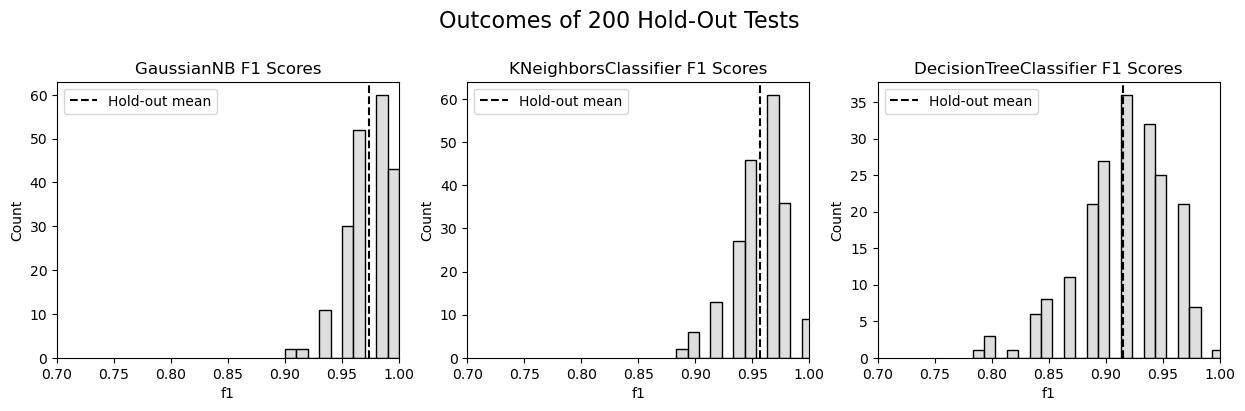

In [18]:
# Create the figure and axes with 1 row and 3 columns
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))

# Create the main title
fig.suptitle("Outcomes of 200 Hold-Out Tests", fontsize=16)

# Create the plots, informing the coordinate
sns.histplot(x = 'f1', data = hold_out_nb_results, binwidth = 0.01, color = '#D3D3D3', ax = axes[0]).set(title = 'GaussianNB F1 Scores', xlim = (0.7, 1))
sns.histplot(x = 'f1', data = hold_out_knn_results, binwidth = 0.01, color = '#D3D3D3', ax = axes[1]).set(title = 'KNeighborsClassifier F1 Scores', xlim = (0.7, 1))
sns.histplot(x = 'f1', data = hold_out_dt_results, binwidth = 0.01, color = '#D3D3D3', ax = axes[2]).set(title = 'DecisionTreeClassifier F1 Scores', xlim = (0.7, 1))

# Add vertical lines at the mean for each model
axes[0].axvline(hold_out_nb_results['f1'].mean(), color = 'black', linestyle = '--')
axes[1].axvline(hold_out_knn_results['f1'].mean(), color = 'black', linestyle = '--')
axes[2].axvline(hold_out_dt_results['f1'].mean(), color = 'black', linestyle = '--')

# Round up the x-axis decimals
for ax in axes:
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
# Add legends to the subplots
axes[0].legend(['Hold-out mean'], loc = 'upper left')
axes[1].legend(['Hold-out mean'], loc = 'upper left')
axes[2].legend(['Hold-out mean'], loc = 'upper left')

# Adjust the subplot layout
fig.subplots_adjust(top = 0.8)

We can observe that in all three models, there are significant differences in F1 scores between the "lucky" and "unlucky" splits. This means that performing hold-out testing with one split of this dataset would be an unreliable measure of model performance since the F1 scores can be anywhere in these ranges depending on the split.

# K-fold Cross Validation<a name="p3"></a>

In this section, we will perform 10-fold cross validations on the same three models used in hold-out testing (GaussianNB, KNeighborsClassifier, and DecisionTreeClassifier).<br><br>
We will first specify the models and the number of folds.

In [19]:
models = [nb, knn, dt]    
folds = 10

We will then evaluate the models using the F1 scores of 10-fold cross validations.

In [20]:
# Create an empty dataframe to store F1 scores
cv_results = pd.DataFrame(columns=['model', 'f1'])

print('F1 Scores:')
for m in models:
    f1_scores = cross_val_score(m, X, y, cv = folds, scoring = 'f1_micro')
    results = {'model': m, 'f1': f1_scores.mean()} # Store results in a dictionary
    cv_results = pd.concat([cv_results, pd.DataFrame(results, index = [0])], ignore_index = True) # Concatenate results to `hold_out_nb`
    print("{} x CV {:22} {:.2f}".format(folds, type(m).__name__, f1_scores.mean())) 

F1 Scores:
10 x CV GaussianNB             0.98
10 x CV KNeighborsClassifier   0.95
10 x CV DecisionTreeClassifier 0.90


Let's visualise the results compared to the distribution of F1 scores from the 200 hold-out tests.

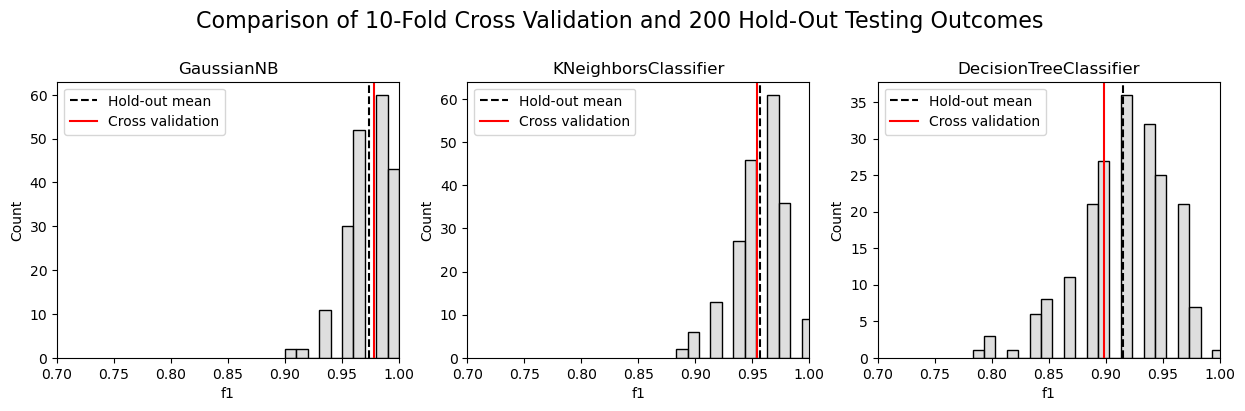

In [21]:
# Create the figure and axes with 1 row and 3 columns
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))

# Create the main title
fig.suptitle("Comparison of 10-Fold Cross Validation and 200 Hold-Out Testing Outcomes", fontsize=16)

# Create the plots, informing the coordinate
sns.histplot(x = 'f1', data = hold_out_nb_results, binwidth = 0.01, color = '#D3D3D3', ax = axes[0]).set(title = 'GaussianNB', xlim = (0.7, 1))
sns.histplot(x = 'f1', data = hold_out_knn_results, binwidth = 0.01, color = '#D3D3D3', ax = axes[1]).set(title = 'KNeighborsClassifier', xlim = (0.7, 1))
sns.histplot(x = 'f1', data = hold_out_dt_results, binwidth = 0.01, color = '#D3D3D3', ax = axes[2]).set(title = 'DecisionTreeClassifier', xlim = (0.7, 1))

# Add vertical lines at the mean for each model
axes[0].axvline(hold_out_nb_results['f1'].mean(), color = 'black', linestyle = '--')
axes[1].axvline(hold_out_knn_results['f1'].mean(), color = 'black', linestyle = '--')
axes[2].axvline(hold_out_dt_results['f1'].mean(), color = 'black', linestyle = '--')

# Add vertical lines at cross validation results for each model
axes[0].axvline(cv_results['f1'].iloc[0], color = 'red', linestyle = '-')
axes[1].axvline(cv_results['f1'].iloc[1], color = 'red', linestyle = '-')
axes[2].axvline(cv_results['f1'].iloc[2], color = 'red', linestyle = '-')

# Round up the x-axis decimals
for ax in axes:
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
# Add legends to the subplots
axes[0].legend(['Hold-out mean', 'Cross validation'], loc = 'upper left')
axes[1].legend(['Hold-out mean', 'Cross validation'], loc = 'upper left')
axes[2].legend(['Hold-out mean', 'Cross validation'], loc = 'upper left')

# Adjust the subplot layout
fig.subplots_adjust(top = 0.8)

In all three models, we can see that the 10-fold cross validation results are neither "lucky" nor "unlucky", but somewhere in the middle. This means that it can give us a more reliable estimate of how our model is likely to perform when it is deployed.<br><br>
Let's plot and compare the confusion matrices for the "lucky" and "unlucky" splits from hold-out testing and the 10-fold cross validation. We will use the results from DecisionTreeClassifier as an example since this model had the largest range in F1 scores from 200 hold-out testings.<br><br>
All three confusion matrices need to be normalised since hold-out testing and cross validation have different numbers of predicted outcomes.

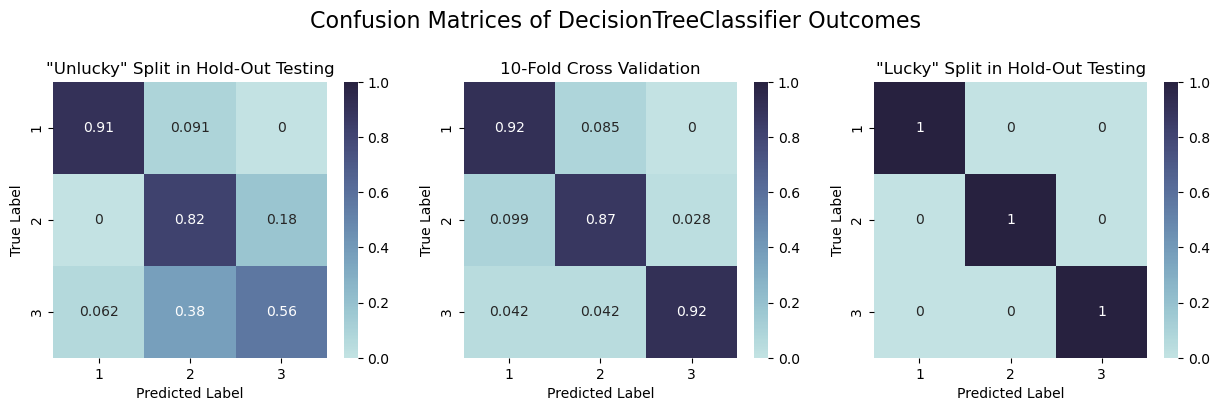

In [22]:
# Define the `y_test` and `y_pred` from the minimum and maximum F1 scores recorded from 200 hold-out testing
dt_y_test_min = hold_out_dt_results.loc[hold_out_dt_results['f1'].idxmin(), 'y_test']
dt_y_pred_min = hold_out_dt_results.loc[hold_out_dt_results['f1'].idxmin(), 'y_pred']
dt_y_test_max = hold_out_dt_results.loc[hold_out_dt_results['f1'].idxmax(), 'y_test']
dt_y_pred_max = hold_out_dt_results.loc[hold_out_dt_results['f1'].idxmax(), 'y_pred']

# Create normalised confusion matrices for the "lucky" and "unlucky" splits
cm_min = confusion_matrix(dt_y_test_min, dt_y_pred_min, normalize = 'true')
cm_max = confusion_matrix(dt_y_test_max, dt_y_pred_max, normalize = 'true')

# Create a normalised confusion matrix for 10-fold cross validation
y_pred_cv = cross_val_predict(dt, X, y, cv=10)
cm_cv = confusion_matrix(y, y_pred_cv, normalize = 'true')

# Create the figure and axes with 1 row and 3 columns
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))

# Create the main title
fig.suptitle("Confusion Matrices of DecisionTreeClassifier Outcomes", fontsize=16)

# Create a colour palette
palette = sns.color_palette("ch:start=.2, rot=-.3", as_cmap=True)

# Create the plots, informing the coordinate
sns.heatmap(cm_min, vmin = 0, vmax = 1, annot = True, xticklabels = dt.classes_, yticklabels = dt.classes_, cmap = palette, ax = axes[0]).set(title = '"Unlucky" Split in Hold-Out Testing', xlabel = 'Predicted Label', ylabel = 'True Label')
sns.heatmap(cm_cv, vmin = 0, vmax = 1, annot = True, xticklabels = dt.classes_, yticklabels = dt.classes_, cmap = palette, ax = axes[1]).set(title = '10-Fold Cross Validation', xlabel = 'Predicted Label', ylabel = 'True Label')
sns.heatmap(cm_max, vmin = 0, vmax = 1, annot = True, xticklabels = dt.classes_, yticklabels = dt.classes_, cmap = palette, ax = axes[2]).set(title = '"Lucky" Split in Hold-Out Testing', xlabel = 'Predicted Label', ylabel = 'True Label')

# Adjust the subplot layout
fig.subplots_adjust(top = 0.8)

We can see that DecisionTreeClassifier struggles with classifying `cultivar = 3` when the split in the hold-out testing is an "unlucky" one. On the other hand, the "lucky" split portrays a perfect classification, making the model appear more accurate than it will be when it is deployed.<br><br>
The outcomes of 10-Fold Cross Validation managed to avoid these extreme estimations of the model's performance and create a more balanced and reliable view.

# Smaller Subset Sizes<a name="p4"></a>

In this section, we will sample subsets of increasing sizes from the dataset and perform hold-out and cross validations to see how they perform with even less data available.<br><br>
For hold-out testing, we will take the average F1 score from 30 tests. The number of folds in K-fold cross validation is decreased to 5 to work with the smallest subset.

In [23]:
# Create an empty dataframe to store validation, percentage, and F1 scores
size_results = pd.DataFrame(columns=['model', 'validation', 'percentage', 'f1'])

# List of validation methods
validation_methods = ['Hold-out', 'K-Fold']

# Create a StratifiedKFold object
# Reduce the number of folds since we're testing with smaller subsets
stratified_kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

# Loop through models and validation methods while increasing sample percentages
for m in models:
    
    # Set a percentage of dataset to sample
    percentage = 0.1
    
    while percentage <= 0.9:
            
        # Create a subset of the dataset
        subset = df.sample(frac = percentage, random_state = 0)

        # Separate `subset` into target class `subset_y` and the rest `subset_X_raw`
        subset_X_raw = subset[subset.columns[1:]]
        subset_y = subset['cultivar']

        # Normalize `subset_X_raw` by scaling each feature between 0 and 1.
        subset_X = scaler.fit_transform(subset_X_raw)
        
        for validation_method in validation_methods:

            if validation_method == 'Hold-out':
                
                # Create an empty list to store F1
                hold_out_list = []
                
                # Run hold-out tests 30 times
                for i in range(30):
                
                    X_train, X_test, y_train, y_test = train_test_split(subset_X, subset_y, random_state = i, test_size = 1/3)

                    # Fit the model and make predictions
                    m.fit(X_train, y_train)
                    y_pred = m.predict(X_test)

                    # Calculate F1 score
                    acc = f1_score(y_test, y_pred, average = 'micro')

                    hold_out_list.append(acc)
                
                # Calulate the average result
                f1 = np.mean(hold_out_list)
            
            else:
                # Perform K-Fold cross-validation
                f1_scores = cross_val_score(m, subset_X, subset_y, cv = stratified_kfold, scoring = 'f1_micro')
                f1 = np.mean(f1_scores)

            # Record the results in the DataFrame
            data = {'model': [m],
                    'validation': [validation_method],
                    'percentage': [percentage],
                    'f1': [f1]}

            results = pd.DataFrame(data)
            size_results = pd.concat([size_results, results], ignore_index=True)
        
        percentage += 0.1

Let's plot and compare the F1 scores from average hold-out tests and the 5-fold cross validations.

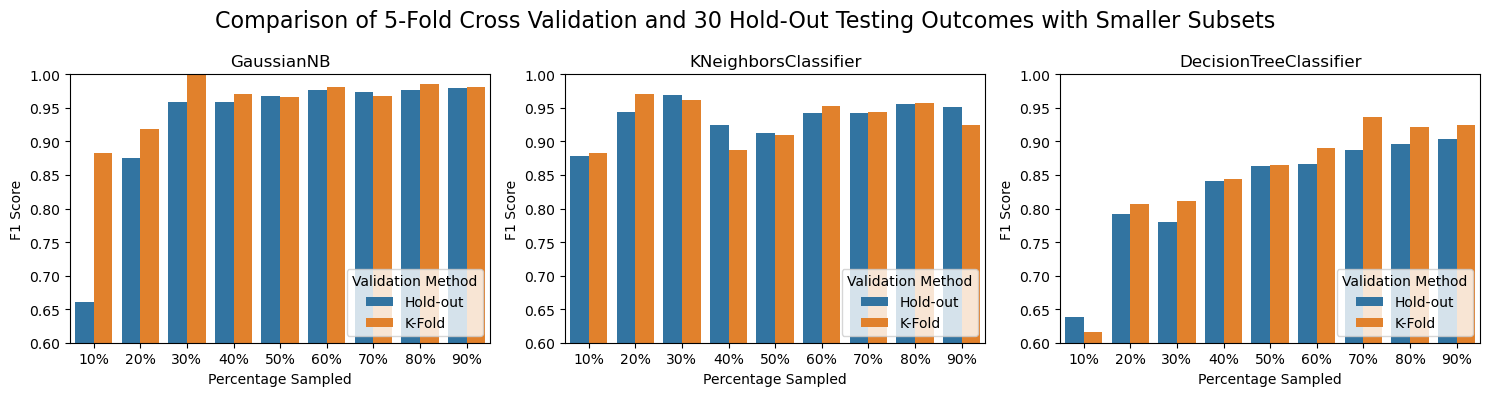

In [24]:
# Create the figure and axes with 1 row and 3 columns
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))

# Create the main title
fig.suptitle("Comparison of 5-Fold Cross Validation and 30 Hold-Out Testing Outcomes with Smaller Subsets", fontsize=16)

# Filter the data for each model
for i, m in enumerate(models):
    model_data = size_results[size_results['model'] == m]

    # Create subplots
    ax = axes[i]
    
    # Set the title for the subplot
    ax.set_title(m.__class__.__name__)
    
    # Plot Hold-out validation results
    sns.barplot(x = 'percentage', y = 'f1', hue = 'validation', data = model_data, ax = ax)
    
    # Set labels and legends
    ax.set_xlabel('Percentage Sampled')
    ax.set_ylabel('F1 Score')
    ax.legend(title = 'Validation Method')
    
    # Set y-axis range
    ax.set_ylim(0.6, 1.0)
    
    # Change x-axis labels to percentages
    x_ticks = size_results['percentage'].unique()
    x_labels = [f'{int(round(x, 1) * 100)}%' for x in x_ticks]
    ax.set_xticklabels(x_labels)
    
    # Display legend in the lower right corner
    ax.legend(title='Validation Method', loc='lower right')
    
plt.tight_layout()
plt.show()

Across the three models, the 5-fold cross validations seem to perform better than average of 30 hold-out tests in most subset sizes smaller than the original dataset of 178 instances.

# Conclusion<a name="conclusion"></a>

* Using `wine.data` which has 178 instances, we observed that hold-out testing has an issue with performance reliability. Training models with 200 different hold-out splits resulted in the F1 score differences of 0.1, 0.12, and 0.22 between "lucky" and "unlucky" splits for GaussianNB, KNeighborsClassifier, and DecisionTreeClassifier models respectively. Performing hold-out testing with one split of this dataset would be an unreliable measure of model performance.<br><br>
* 10-fold cross validation on the other hand showed more robust results for all three models compared to hold-out testing.<br><br>
* Sampling subsets of increasing sizes from the dataset has shown that 5-fold cross validations performs better than average of 30 hold-out tests in most subset sizes smaller than the original dataset of 178 instances.<br><br>
* We can conclude that K-fold cross validation provides	a more stable, and better estimate of performance on small amounts of data.	It is beneficial to use all the data for training and testing when there is less data available. Given that the full size of the dataset is 178 instances, there is also scope to increase the number of folds to aim for even better robustness without causing a high computational cost.

#  References<a name="ref"></a>

1. <a name="1"></a>Kelleher, J. D., Mac Namee, B., & D'arcy, A. (2020). Fundamentals of machine learning for predictive data analytics: algorithms, worked examples, and case studies. MIT press.
2. <a name="2"></a>UC Irvine Machine Learning Repository. (n.d.). https://archive-beta.ics.uci.edu/dataset/109/wine